In [1]:
import datetime as dt
import itertools as it
import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from recsys4daos.utils import notebooks as nbutils
from recsys4daos.model_selection import cvtt_open
import paths

sns.set_theme(rc = {
})
sns.set_context("paper")

# Paper column width in inches
PAPER_COL_WIDTH = 3.5

original = plt.rcParamsDefault['figure.figsize']
ratio = original[0] / original[1]
print(f"Original size: {original}, Ratio: {ratio}")
plt.rcParams['figure.figsize'] = (PAPER_COL_WIDTH, PAPER_COL_WIDTH/ratio)
print("New size:", plt.rcParams['figure.figsize'])

# In acmart, 9pt is the default
# And 7pt for \footnotesize
# plt.rcParams['font.size'] = 7,

# The following are already relatively defined
# plt.rcParams['xtick.labelsize'] = plt.rcParams['ytick.labelsize'] = plt.rcParams['axes.labelsize'] = plt.rcParams['font.size']

Original size: [6.4, 4.8], Ratio: 1.3333333333333335
New size: [3.5, 2.6249999999999996]


/home/daviddavo/recsys4daos/src/recsys4daos/model_selection.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
ORG_NAME = 'Decentraland'
SPLITS_FREQ: str = 'W-THU'
SPLITS_NORMALIZE: bool = True
LAST_FOLDS: int = 10
LAST_FOLD_DATE_STR: str = None # Used just for plotting

# Plotting hparams
RECTANGLE_ALPHA = 0.3

In [3]:
# Parameters
EXECUTION_ID = "2024-09-24T10:00"
MIN_BATCH_SIZE = 4
ORG_NAME = "Magic Square"
SPLITS_FREQ = "7d"
LAST_FOLDS = 10
SPLITS_NORMALIZE = True
LAST_FOLD_DATE_STR = "2023-07-17"


In [4]:
LAST_FOLD_DATE: dt.datetime = dt.datetime.fromisoformat(LAST_FOLD_DATE_STR) if LAST_FOLD_DATE_STR else dt.datetime.now()

In [5]:
dfp = paths.load_proposals(ORG_NAME)
dfv = paths.load_votes(ORG_NAME)

print(dfp.info())
print(dfv.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316 entries, 0 to 315
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 316 non-null    object        
 1   author             316 non-null    object        
 2   date               316 non-null    datetime64[us]
 3   start              316 non-null    datetime64[us]
 4   end                316 non-null    datetime64[us]
 5   platform_proposal  316 non-null    object        
dtypes: datetime64[us](3), object(3)
memory usage: 14.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899961 entries, 0 to 899960
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   id        899961 non-null  object        
 1   proposal  899961 non-null  object        
 2   voter     899961 non-null  object        
 3   date      899961 non-null  datetime64[us]

In [6]:
print("First vote:", first_vote := dfv['date'].min())
print("Last vote:", last_vote := dfv['date'].max())
paths.save_dao_datum(ORG_NAME, 'dfv_first_vote', str(first_vote))
paths.save_dao_datum(ORG_NAME, 'dfv_last_vote', str(last_vote))

First vote: 2023-05-08 11:56:03
Last vote: 2023-07-20 08:19:43


In [7]:
folds = list(cvtt_open(dfv, SPLITS_FREQ, dfp, normalize=SPLITS_NORMALIZE, col_item='proposal', col_time='date', last_fold=LAST_FOLD_DATE_STR))[-LAST_FOLDS:]
print(f"Using {len(folds)} folds from {folds[0].end} to {folds[-1].end}")
paths.save_dao_datum(ORG_NAME, 'first_fold_date', str(folds[0].end))

Using 10 folds from 2023-05-15 00:00:00 to 2023-07-17 00:00:00


## Proposals and time

### How much time does each proposal take

14 days    316
Name: count, dtype: int64
14 days    1.0
Name: count, dtype: float64


count                 316
mean     14 days 00:00:00
std       0 days 00:00:00
min      14 days 00:00:00
25%      14 days 00:00:00
50%      14 days 00:00:00
75%      14 days 00:00:00
max      14 days 00:00:00
dtype: object

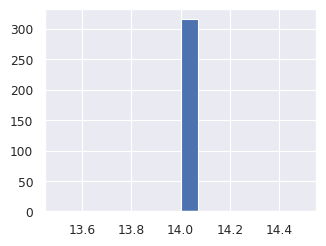

In [8]:
# Original: Cell [5] at https://github.com/daviddavo/upm-tfm-notebooks/blob/bb2e45d4ec10962c987b6691fcb0cd4eeba7ea5b/10_baseline_mp.ipynb

delta = dfp['end'] - dfp['start']
delta.dt.days.hist(bins=14)
print(vc := delta.value_counts())
print(vc / len(delta))
paths.save_dao_datum(ORG_NAME, 'median_open_time', str(delta.median()))
delta.describe()

#### Avg. proposal length in time

In [9]:
def add_folds_to_plot(fig=plt, cont=True):

    if cont:
        start_date = folds[0].end
        end_date = folds[-1].end
        fig.axvspan(start_date, end_date, color='C2', alpha=RECTANGLE_ALPHA)
    else:
        for fprev, f, c in zip(folds, folds[1:], it.cycle([0,1])):
            start_date = fprev.end
            end_date = f.end
            fig.axvspan(start_date, end_date, alpha=RECTANGLE_ALPHA, color='C1' if c else 'C2')

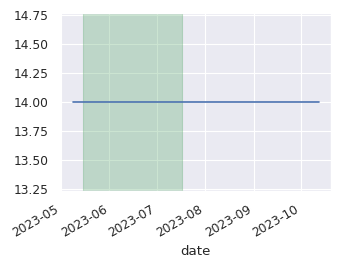

In [10]:
# Original: Cell [6] at https://github.com/daviddavo/upm-tfm-notebooks/blob/bb2e45d4ec10962c987b6691fcb0cd4eeba7ea5b/10_baseline_mp.ipynb
ROLLING_LENGTH = '7d'

_delta = dfp.assign(delta=delta).set_index('date').sort_index()['delta'].dt.days
_delta.rolling(ROLLING_LENGTH).mean().plot()

add_folds_to_plot()

## How many proposals are created per week

26.0
2023-07-04 08:33:49


<Figure size 350x262.5 with 0 Axes>

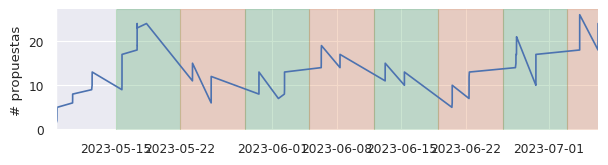

In [11]:
WINDOW_SIZE = '7d' # dt.timedelta(days=7)

_toplot = dfv.groupby('proposal')['date'].min().sort_values()
_toplot = _toplot.to_frame()
_toplot['cnt'] = 1
_toplot = _toplot.rolling(window=WINDOW_SIZE, on='date').count()
print(max_cnt := _toplot['cnt'].max())
print(max_date := _toplot[_toplot['cnt'] == max_cnt].iloc[0]['date'])
paths.save_dao_datum(ORG_NAME, 'max_proposals_ws', WINDOW_SIZE)
paths.save_dao_datum(ORG_NAME, 'max_proposals_cnt', int(max_cnt))
paths.save_dao_datum(ORG_NAME, 'max_proposals_date', str(max_date))

# Double the width of the figure
fs = plt.gcf().get_size_inches()
plt.figure(figsize=fs * (2,.6))
# _toplot.set_index('date')['cnt'].plot()
ax = sns.lineplot(_toplot.set_index('date')['cnt'])

plt.xlabel('')
plt.ylabel('# propuestas')
plt.xlim(
    _toplot['date'].min(),
    _toplot['date'].max(),
)
add_folds_to_plot(cont=False)

sns.despine()

<Figure size 350x262.5 with 0 Axes>

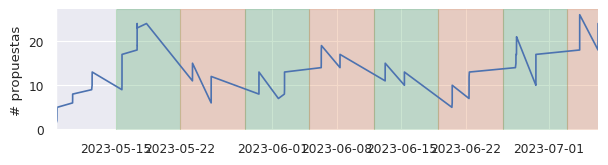

In [12]:
_toplot = _toplot[_toplot['date'] > (folds[0].end - pd.tseries.frequencies.to_offset(SPLITS_FREQ)*3)]
_toplot = _toplot[_toplot['date'] < (folds[-1].end + pd.tseries.frequencies.to_offset(SPLITS_FREQ)*3)]
fs = plt.gcf().get_size_inches()
plt.figure(figsize=fs * (2,.6))
# _toplot.set_index('date')['cnt'].plot()
ax = sns.lineplot(_toplot.set_index('date')['cnt'])

plt.xlabel('')
plt.ylabel('# propuestas')
plt.xlim(
    _toplot['date'].min(),
    _toplot['date'].max(),
)
add_folds_to_plot(cont=False)

sns.despine()

## Queue size (open proposals)

41
2023-07-13 00:00:00


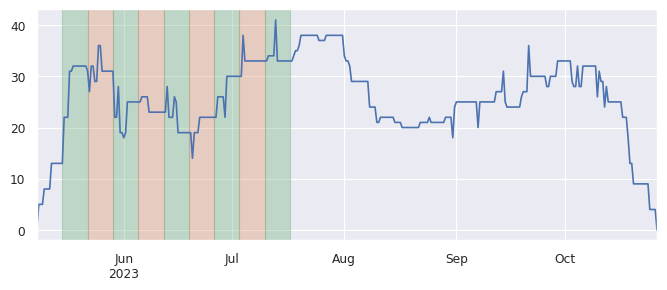

In [13]:
# This will be the "resolution" of the graph
_GROUPER_FREQ = '12h'

df_events = pd.concat((
    dfp.groupby('start').size(),
    -dfp.groupby('end').size(),
)).sort_index()
qsize = df_events.groupby(pd.Grouper(freq=_GROUPER_FREQ)).sum().cumsum()

print(max_qsize := qsize.max())
print(max_date := qsize[qsize == max_qsize].index[0])
paths.save_dao_datum(ORG_NAME, 'max_open_freq', _GROUPER_FREQ)
paths.save_dao_datum(ORG_NAME, 'max_open_cnt', int(max_qsize))
paths.save_dao_datum(ORG_NAME, 'max_open_date', str(max_date))

qsize.plot(figsize=(8,3))
add_folds_to_plot(cont=False)

41
2023-07-13 00:00:00


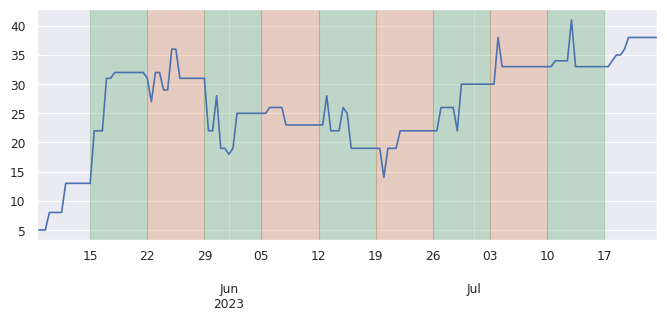

In [14]:
_toplot = qsize[qsize.index > (folds[0].end - pd.tseries.frequencies.to_offset(SPLITS_FREQ)*1)]
_toplot = _toplot[_toplot.index < (folds[-1].end + pd.tseries.frequencies.to_offset(SPLITS_FREQ)*1)]

print(max_qsize := _toplot.max())
print(max_date := _toplot[_toplot == max_qsize].index[0])
paths.save_dao_datum(ORG_NAME, 'max_open_freq_test', _GROUPER_FREQ)
paths.save_dao_datum(ORG_NAME, 'max_open_cnt_test', int(max_qsize))
paths.save_dao_datum(ORG_NAME, 'max_open_date_test', str(max_date))

_toplot.plot(figsize=(8,3))
add_folds_to_plot(cont=False)

## What day of the week are proposals created

start
Tuesday      137
Thursday     126
Friday        20
Wednesday     19
Monday        14
Name: count, dtype: int64


/tmp/ipykernel_1809112/3307774390.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(DAYS_OF_WEEK_ENG, rotation=30, ha='right')


Cannot show ipywidgets in text

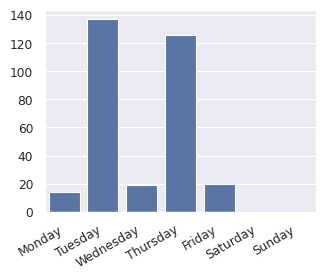

In [15]:
# Original: Cell [7] at https://github.com/daviddavo/upm-tfm-notebooks/blob/bb2e45d4ec10962c987b6691fcb0cd4eeba7ea5b/10_baseline_mp.ipynb
DAYS_OF_WEEK_ENG = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

ax = sns.countplot(x=dfp['start'].dt.day_name(), order=DAYS_OF_WEEK_ENG)
# ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
print(dfp['start'].dt.day_name().value_counts())
ax.set_xlabel('')
ax.set_ylabel('# proposals')
ax.set_xticklabels(DAYS_OF_WEEK_ENG, rotation=30, ha='right')

# Updates
ax.set_ylabel('')

nbutils.download_matplotlib(ax.figure, 'proposals_dow.pdf')

## What day of the week are proposals voted

date
Saturday     179793
Wednesday    143948
Friday       139484
Monday       122084
Thursday     119009
Tuesday      105666
Sunday        89977
Name: count, dtype: int64


/tmp/ipykernel_1809112/3643726510.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(DAYS_OF_WEEK_ENG, rotation=30, ha='right')


Cannot show ipywidgets in text

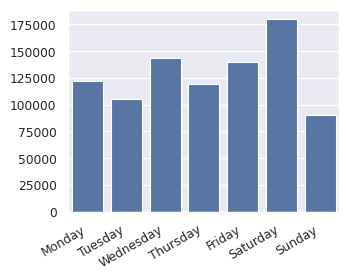

In [16]:
ax = sns.countplot(x=dfv['date'].dt.day_name(), order=DAYS_OF_WEEK_ENG)
# ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
print(dfv['date'].dt.day_name().value_counts())
ax.set_xlabel('')
ax.set_ylabel('# votes')
ax.set_xticklabels(DAYS_OF_WEEK_ENG, rotation=30, ha='right')

# Updates
ax.set_ylabel('')

nbutils.download_matplotlib(ax.figure, "votes_dow.pdf")

## In which moment of the proposal lifetime are votes cast

time remaining                                                   \
                 count      mean       std       min      25%       50%   
delta                                                                     
14 days       899961.0  0.632884  0.267802  0.000004  0.43254  0.684943   

                            
              75%      max  
delta                       
14 days  0.870006  0.99999

251495 (27.95%) of the votes are being cast on the first 14.29% of rel time
847688 (94.19%) of the votes are being cast on the first 85.71% of rel time


Cannot show ipywidgets in text

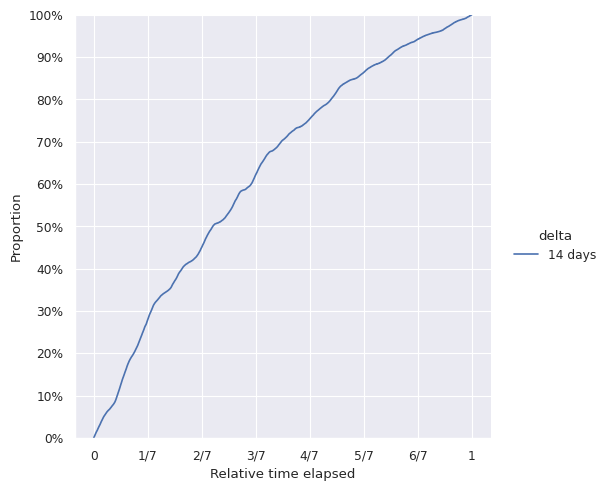

In [17]:
from matplotlib import ticker

PLOT_HUE = True
BINS = 10

_dfv = dfv[['proposal', 'date']].merge(dfp[['id', 'start', 'end']], left_on='proposal', right_on='id').sort_values('date')
if not all(_dfv['date'] >= _dfv['start']):
    warnings.warn('There cant be votes before the proposal started')
if not all(_dfv['end'] >= _dfv['date']):
    warnings.warn('There cant be votes after the proposal ended')
_dfv['date_rel'] = (_dfv['date'] - _dfv['start']) / (_dfv['end'] - _dfv['start'])
_dfv['delta'] = (_dfv['end'] - _dfv['start'])
_dfv['time remaining'] = 1 - _dfv['date_rel']

display(_dfv.groupby('delta')[['time remaining']].describe())

for t in [1/7, 6/7]:
    first_day = (_dfv['date_rel'] < t)
    print(f"{first_day.sum()} ({first_day.mean()*100:.2f}%) of the votes are being cast on the first {t*100:.2f}% of rel time")

if len(_dfv['delta'].value_counts()) > BINS:
    _dfv['delta_original'] = _dfv['delta']
    _dfv['delta'] = pd.cut(_dfv['delta'], BINS)

_dfv['delta'] = _dfv['delta'].astype(str)
fg = sns.displot(_dfv, x='date_rel', kind='ecdf', hue='delta' if PLOT_HUE else None)
# fg.ax.xaxis.set_major_locator(ticker.MultipleLocator(1/7))

fg.ax.yaxis.set_major_locator(ticker.MultipleLocator(1/10))
fg.ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))
fg.ax.set_xticks(np.arange(8)/7)
fg.ax.set_xticklabels(["0"] + [f"{x}/7" for x in range(1,7)] + ["1"])
fg.ax.set_xlabel('Relative time elapsed');

nbutils.download_matplotlib(fg, f"votes_in_time{'-color' if PLOT_HUE else ''}.pdf")

## Explore folds

### Just the folds that are used

In [18]:
from collections import defaultdict

foldsinfo = defaultdict(list)
for f in folds:
    # print(len(f.open_proposals), "open proposals")
    foldsinfo['t'].append(f.end)
    foldsinfo['open proposals'].append(len(f.open_proposals))
    foldsinfo['users in train'].append(f.train['voter'].nunique())
    foldsinfo['users in test'].append(f.test['voter'].nunique())
    foldsinfo['votes in train'].append(len(f.train))
    foldsinfo['votes in test'].append(len(f.test))
    foldsinfo['users in both'].append(len(np.intersect1d(f.test['voter'].unique(), f.test['voter'].unique())))
    # votes per proposal
    foldsinfo['vpp test'].append(f.test.groupby('proposal').size().mean())
    # votes per voter
    foldsinfo['vpv test'].append(f.test.groupby('voter').size().mean())

dff = pd.DataFrame(foldsinfo).set_index('t')
paths.save_dao_datum(ORG_NAME, 'folds_avg_open_proposals', dff['open proposals'].mean())
paths.save_dao_datum(ORG_NAME, 'folds_avg_test_votes', dff['votes in test'].mean())
paths.save_dao_datum(ORG_NAME, 'folds_avg_test_users', dff['users in test'].mean())
paths.save_dao_datum(ORG_NAME, 'folds_avg_test_vpp', dff['vpp test'].mean())
paths.save_dao_datum(ORG_NAME, 'folds_avg_test_vpv', dff['vpv test'].mean())
dff

,open proposals,users in train,users in test,votes in train,votes in test,users in both,vpp test,vpv test
t,,,,,,,,
2023-05-15,13,1518,927,8749,5798,927,446.000000,6.254585
2023-05-22,32,2668,2253,22639,20797,2253,649.906250,9.230803
2023-05-29,31,5046,7337,52766,46807,7337,1509.903226,6.379583
2023-06-05,25,11200,9093,122736,61093,9093,2443.720000,6.718685
2023-06-12,23,17262,7841,200990,55804,7841,2426.260870,7.116949
2023-06-19,19,23522,5712,299068,39614,5712,2084.947368,6.935224
2023-06-26,22,25944,15287,382096,84820,15287,3855.454545,5.548505
2023-07-03,30,44192,9501,635264,78066,9501,2602.200000,8.216609
2023-07-10,33,48097,16389,767025,132936,16389,4028.363636,8.111294


## Histograms

### Votes per user

count    56774.000000
mean        15.851640
std         16.475796
min          1.000000
10%          2.000000
15%          3.000000
50%         10.000000
90%         35.000000
95%         46.000000
99%         89.000000
max        122.000000
dtype: float64
26699 voters (47.03%) have voted more than 10 times
321 voters (0.57%) have voted more than 100 times


Cannot show ipywidgets in text

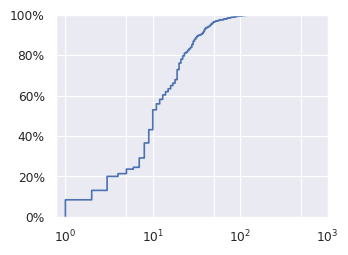

In [19]:
_toplot = dfv.groupby('voter').size()
# _toplot = _toplot[_toplot < 40]
print(_toplot.describe(percentiles=[.1, .15, .5, .9, .95, .99]))
# _toplot.plot.hist(log=True)
ax = sns.ecdfplot(_toplot, log_scale=True)
plt.xlabel('# votes')
plt.ylabel('% voters')

_times_voted = [10, 100]
for t in _times_voted:
    _nusers = (_toplot > t).sum()
    print(f"{_nusers} voters ({_nusers/len(_toplot)*100:.2f}%) have voted more than {t} times")

ax.set_xticks([1, 5, 10, 50, 100, 500, 1000])
# ax.xaxis.set_major_locator(mtick.MultipleLocator(10))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))

# Updates by Javi
plt.xlabel("")
plt.ylabel("")

nbutils.download_matplotlib(ax.figure, "ecdf-vpv.pdf")

### Votes per proposal

count      122.000000
mean      7376.729508
std       5211.323358
min        965.000000
10%       1143.100000
15%       1241.450000
20%       1778.600000
25%       1991.500000
50%       7522.500000
75%       9748.250000
90%      12902.200000
95%      17505.150000
99%      22893.880000
max      23372.000000
dtype: float64
Total votes: 899961
122 proposals (100.00%) have more than 10 votes
122 proposals (100.00%) have more than 72 votes
122 proposals (100.00%) have more than 73 votes
122 proposals (100.00%) have more than 100 votes


Cannot show ipywidgets in text

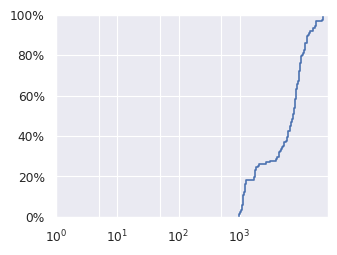

In [20]:
_toplot = dfv.groupby('proposal').size()
print(_toplot.describe(percentiles=[.1, .15, .20, .25, .5,.75,.9, .95, .99]))

print("Total votes:", _toplot.sum())
_times_voted = [10, 72, 73, 100]
for t in _times_voted:
    _nprops = (_toplot > t).sum()
    print(f"{_nprops} proposals ({_nprops/len(_toplot)*100:.2f}%) have more than {t} votes")

ax = sns.ecdfplot(_toplot, log_scale=True)
ax.set_xticks([1, 5, 10, 50, 100, 500, 1000])
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))

plt.xlabel('# votes')
plt.ylabel('% proposals')

# Updates by Javi
plt.xlabel("")
plt.ylabel("")

nbutils.download_matplotlib(ax.figure, "ecdf-vpp.pdf")